<a href="https://colab.research.google.com/github/jhuang12/Tensorflow-for-personality-items-classification/blob/master/191216TF_IPIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#THIS NOTEBOOK WAS CREATED TO USE TF NLP FOR IPIP ITEMS

In [0]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf

In [2]:
print(tf.__version__)

1.15.0


In [2]:
!pip install tensorflow==2.0.0

DATA LOADING

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dpath = os.path.join(r"C:/Users/amead/Google Drive/active/machine learning/big5/big_five_items.csv")
dpath = os.path.join("/content/drive/My Drive/big_five_items.csv")

In [0]:
data = pd.read_csv(dpath,low_memory = False, sep = "\t", lineterminator = '\n', encoding = 'utf-8')

DATA PROCESSING


In [0]:
#stem as one string
sentences = pd.Series(data['Stem'])

In [0]:
#scale as categorical data
data['labels'] = data['Scale'].astype('category').cat.codes

In [0]:
labels = np.array(pd.Series(data['labels']))

DATA CLEANING (STEMMING)

TOKENIZATION AND PADDING

In [0]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(oov_token = "<OOV>", num_words = 10000)
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index
# print(word_index)

# sequences = tokenizer.texts_to_sequences(sentences)
# padded = pad_sequences(sequences, padding = 'pre')
# print(padded[0])
# print(padded.shape)

In [0]:
#split training and validation sample
#training_data, training_labels = np.asarray(padded[ :524]), labels[ :524]
#test_data, test_labels = np.asarray(padded[525: ]), labels[525: ]

TRAINING

In [0]:
import random 
random.seed(700)

In [0]:
#stratified random sampling training and validation sample by dimensions

training_data = []
training_labels = []
validation_data = []
validation_labels = []

for s in range(5):
  training_set = data.loc[data['labels'] == s, 'Stem'].sample(frac = 0.7, replace = False, random_state = 1)
  training_l = np.array([s]*len(training_set))

  validation_set = data.loc[(~data['Stem'].isin(training_set)) & (data['labels'] == s), 'Stem']
  validation_l = np.array([s]*len(validation_set))

  training_data.extend(training_set)
  training_labels.extend(training_l)

  validation_data.extend(validation_set)
  validation_labels.extend(validation_l)

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = 10000

def sequence_vectorization (train_texts, val_texts): 
  """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
  """
  tokenizer = Tokenizer(oov_token = "<OOV>", num_words = MAX_LENGTH)
  # Create vocabulary with training texts.
  tokenizer.fit_on_texts(train_texts)
  x_train = tokenizer.texts_to_sequences(train_texts)
  x_val = tokenizer.texts_to_sequences(val_texts)
  
  # Get max sequence length.
  max_length = len(max(x_train, key=len))
  
  if max_length > MAX_LENGTH:
    max_length = MAX_LENGTH
 
# Fix sequence length to max value. Sequences shorter than the length are
# padded in the beginning and sequences longer are truncated
# at the beginning.
  x_train = np.asarray(pad_sequences(x_train, maxlen=max_length))
  x_val = np.asarray(pad_sequences(x_val, maxlen=max_length))

  return x_train, x_val, tokenizer.word_index

In [0]:
train_vec, val_vec, word_index = sequence_vectorization(training_data, validation_data)

In [0]:
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

In [0]:
#summary of tokenization - validation data
# print(tokenizer.word_counts)
# print(tokenizer.document_count)
# print(tokenizer.word_index)
# print(tokenizer.word_docs)

MODEL BUILING - MLP

In [0]:
ACCURACY_STOP = 0.95

class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy')> ACCURACY_STOP):
      self.model.stop_training = True
      print("\nReach accuracy of 95% and stop training!")

callbacks = myCallbacks()

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_directory = '/content/drive/My Drive/NLP_tensorflow/sequentia_model.h5'

checkpoint = ModelCheckpoint(checkpoint_directory,
                             monitor = "val_accuracy", 
                             save_best_only = True, 
                             mode = 'max')

In [0]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [0]:
def mlp_model(layers, units, dropout_rate, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    #model.add(Dropout(rate = dropout_rate)
    
    for i in range(layers-1):
      model.add(Dense(units = units, activation='sigmoid'))
      #model.add(Dropout(rate = dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [0]:
layers = 4
units = 12
dropout_rate = 0.1
#input_shape = 1
num_classes = 5

In [0]:
mlp_model = mlp_model(layers, units, dropout_rate, num_classes)

In [0]:
mlp_model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [74]:
NUM_EPOCHS = 50
history = mlp_model.fit(train_vec, training_labels,
                    validation_data = (val_vec, validation_labels),
                    epochs = NUM_EPOCHS, 
                    callbacks = [checkpoint, callbacks])

Train on 459 samples, validate on 183 samples
Epoch 1/50
459/459 [==============================] - 1s 1ms/sample - loss: 1.6319 - accuracy: 0.1983 - val_loss: 1.6166 - val_accuracy: 0.2022
Epoch 2/50
459/459 [==============================] - 0s 102us/sample - loss: 1.6192 - accuracy: 0.1983 - val_loss: 1.6105 - val_accuracy: 0.2022
Epoch 3/50
459/459 [==============================] - 0s 94us/sample - loss: 1.6120 - accuracy: 0.1983 - val_loss: 1.6084 - val_accuracy: 0.2077
Epoch 4/50
459/459 [==============================] - 0s 106us/sample - loss: 1.6088 - accuracy: 0.1961 - val_loss: 1.6077 - val_accuracy: 0.2459
Epoch 5/50
459/459 [==============================] - 0s 103us/sample - loss: 1.6074 - accuracy: 0.2048 - val_loss: 1.6081 - val_accuracy: 0.1749
Epoch 6/50
459/459 [==============================] - 0s 111us/sample - loss: 1.6070 - accuracy: 0.2266 - val_loss: 1.6083 - val_accuracy: 0.2186
Epoch 7/50
459/459 [==============================] - 0s 106us/sample - loss: 1.6

MODEL BUILDING CNN, RNN, AND LSTM

In [0]:
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(1000, 16),
      tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(64, activation = 'relu'),
      tf.keras.layers.Dense(16, activation ='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          16000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 35,749
Trainable params: 35,749
Non-trainable params: 0
____________________________________________________

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [0]:
def cnn_model(layers, units, num_classes):
  """ create an instance of CNN model. 

      # Arguments
          layers: int, number of `Dense` layers in the model.
          units: int, output dimension of the layers.
          dropout_rate: float, percentage of input to drop at Dropout layers.
          num_classes: int, number of output classes.

      # Returns
          A CNN model instance.

  """
  op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
  model = models.Sequential()
  model.add(Embedding(1000, 16))
  model.add(Conv1D(64, 5, activation = 'relu'))
  model.add(GlobalAveragePooling1D())
    
  for i in range(layers-1):
    model.add(Dense(units = units, activation ='relu'))
    #model.add(Dropout(rate = dropout_rate))
    units = units//2

  model.add(Dense(units=op_units, activation=op_activation))

  return model

In [0]:
layers = 4
units = 256
dropout_rate = 0.1
#input_shape = 1
num_classes = 5

In [0]:
model = cnn_model(layers, units, num_classes)

In [0]:
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          16000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          5184      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                

In [62]:
NUM_EPOCHS = 50
history = model.fit(train_vec, training_labels,
                    validation_data = (val_vec, validation_labels),
                    epochs = NUM_EPOCHS, 
                    callbacks = [checkpoint, callbacks])

Train on 459 samples, validate on 183 samples
Epoch 1/50
459/459 [==============================] - 1s 2ms/sample - loss: 1.6111 - accuracy: 0.1983 - val_loss: 1.6093 - val_accuracy: 0.2077
Epoch 2/50
459/459 [==============================] - 0s 237us/sample - loss: 1.6103 - accuracy: 0.1634 - val_loss: 1.6094 - val_accuracy: 0.2077
Epoch 3/50
459/459 [==============================] - 0s 245us/sample - loss: 1.6096 - accuracy: 0.1961 - val_loss: 1.6093 - val_accuracy: 0.1913
Epoch 4/50
459/459 [==============================] - 0s 232us/sample - loss: 1.6097 - accuracy: 0.1721 - val_loss: 1.6089 - val_accuracy: 0.2131
Epoch 5/50
459/459 [==============================] - 0s 234us/sample - loss: 1.6091 - accuracy: 0.2092 - val_loss: 1.6083 - val_accuracy: 0.2350
Epoch 6/50
459/459 [==============================] - 0s 234us/sample - loss: 1.6048 - accuracy: 0.2723 - val_loss: 1.6036 - val_accuracy: 0.2623
Epoch 7/50
459/459 [==============================] - 0s 246us/sample - loss: 1.

MODEL PERFORMANCE

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

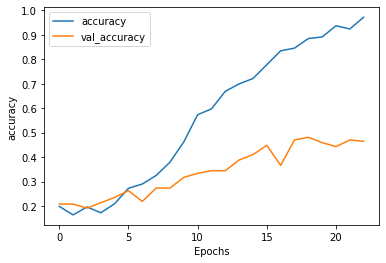

In [64]:
plot_graphs(history, 'accuracy')

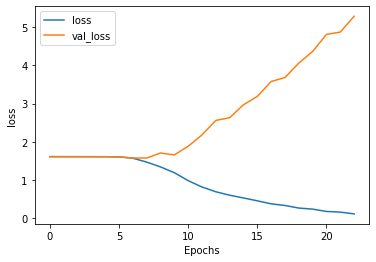

In [65]:
plot_graphs(history, 'loss')

USE SINGLE LAYER LSTM

In [0]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 138,629
Trainable params: 138,629
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.layers import Bidirectional

In [0]:
def lstm_1l(layers, units, lstm_layer, num_classes):
  """create an instance of a single layer LSTM. 

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        num_classes: int, number of output classes.

    # Returns
        A single layer LSTM model instance.
  """
  op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
  model = models.Sequential()
  model.add(Embedding(1000, 16))
  model.add(Bidirectional(tf.keras.layers.LSTM(lstm_layer)))

    
  for i in range(layers-1):
    model.add(Dense(units = units, activation ='relu'))
    #model.add(Dropout(rate = dropout_rate))
    units = units//2

  model.add(Dense(units=op_units, activation=op_activation))

  return model

In [0]:
layers = 4
units = 256
dropout_rate = 0.1
#input_shape = 1
lstm_layer = 64
num_classes = 5

In [0]:
model1 = lstm_1l(layers, units, lstm_layer, num_classes)

In [90]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               41472     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 325       
Total params: 131,973
Trainable params: 131,973
Non-trainable params: 0
________________________________________________

In [0]:
model1.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [92]:
model1.fit(train_vec, training_labels,
          validation_data=(val_vec, validation_labels),
          epochs=50, 
          callbacks = [ callbacks])

Train on 459 samples, validate on 183 samples
Epoch 1/50
459/459 [==============================] - 5s 10ms/sample - loss: 1.6103 - accuracy: 0.1743 - val_loss: 1.6095 - val_accuracy: 0.1858
Epoch 2/50
459/459 [==============================] - 0s 1ms/sample - loss: 1.6094 - accuracy: 0.2113 - val_loss: 1.6085 - val_accuracy: 0.2022
Epoch 3/50
459/459 [==============================] - 0s 1ms/sample - loss: 1.6063 - accuracy: 0.2288 - val_loss: 1.6011 - val_accuracy: 0.3169
Epoch 4/50
459/459 [==============================] - 0s 1ms/sample - loss: 1.5735 - accuracy: 0.4161 - val_loss: 1.5660 - val_accuracy: 0.2350
Epoch 5/50
459/459 [==============================] - 0s 1ms/sample - loss: 1.4151 - accuracy: 0.4336 - val_loss: 1.4191 - val_accuracy: 0.3607
Epoch 6/50
459/459 [==============================] - 0s 1ms/sample - loss: 1.0290 - accuracy: 0.5643 - val_loss: 1.3994 - val_accuracy: 0.4153
Epoch 7/50
459/459 [==============================] - 0s 1ms/sample - loss: 0.7222 - accu

USE MULTIPLE LAYER LSTM

In [0]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [59]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 176,549
Trainable params: 176,549
Non-trainable params: 0
________________________________________________

In [0]:
model2.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
)

In [64]:
model2.fit(train_vec, training_labels,
           validation_data=(val_vec, validation_labels),
           epochs=30, 
           callbacks = [ callbacks])

Train on 459 samples, validate on 183 samples
Epoch 1/30
459/459 [==============================] - 7s 15ms/sample - loss: 1.6100 - accuracy: 0.2026 - val_loss: 1.6082 - val_accuracy: 0.2131
Epoch 2/30
459/459 [==============================] - 1s 2ms/sample - loss: 1.6080 - accuracy: 0.2048 - val_loss: 1.6060 - val_accuracy: 0.2295
Epoch 3/30
459/459 [==============================] - 1s 2ms/sample - loss: 1.5995 - accuracy: 0.2941 - val_loss: 1.5953 - val_accuracy: 0.2896
Epoch 4/30
459/459 [==============================] - 1s 2ms/sample - loss: 1.5403 - accuracy: 0.3682 - val_loss: 1.5020 - val_accuracy: 0.3060
Epoch 5/30
459/459 [==============================] - 1s 2ms/sample - loss: 1.2583 - accuracy: 0.4183 - val_loss: 1.5028 - val_accuracy: 0.4098
Epoch 6/30
459/459 [==============================] - 1s 2ms/sample - loss: 1.0714 - accuracy: 0.5839 - val_loss: 1.4754 - val_accuracy: 0.4317
Epoch 7/30
459/459 [==============================] - 1s 2ms/sample - loss: 0.8174 - accu

USE GRU

In [0]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, 64, input_length=24),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 64)            64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 35        
Total params: 83,241
Trainable params: 83,241
Non-trainable params: 0
_________________________________________________________________


In [0]:
model3.fit(training_data, training_labels,
                    validation_data=(test_data, test_labels),
                    epochs=30, 
                    callbacks = [ callbacks])

Train on 524 samples, validate on 130 samples
Epoch 1/30
524/524 [==============================] - 4s 7ms/sample - loss: 1.6102 - accuracy: 0.2099 - val_loss: 1.6057 - val_accuracy: 0.2462
Epoch 2/30
524/524 [==============================] - 0s 662us/sample - loss: 1.5952 - accuracy: 0.2538 - val_loss: 1.6034 - val_accuracy: 0.2000
Epoch 3/30
524/524 [==============================] - 0s 628us/sample - loss: 1.5684 - accuracy: 0.2309 - val_loss: 1.5907 - val_accuracy: 0.2308
Epoch 4/30
524/524 [==============================] - 0s 686us/sample - loss: 1.5167 - accuracy: 0.2653 - val_loss: 1.5860 - val_accuracy: 0.2231
Epoch 5/30
524/524 [==============================] - 0s 658us/sample - loss: 1.4132 - accuracy: 0.3588 - val_loss: 1.6173 - val_accuracy: 0.3231
Epoch 6/30
524/524 [==============================] - 0s 630us/sample - loss: 1.2616 - accuracy: 0.4866 - val_loss: 1.5625 - val_accuracy: 0.3538
Epoch 7/30
524/524 [==============================] - 0s 637us/sample - loss: 1.

In [0]:
#clear the trained models
tf.keras.backend.clear_session()